<a href="https://colab.research.google.com/github/MathieuFan22/Mirada-Examen-ML-M2-ISPM/blob/Tsiky/PoketraFinday-Mirada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!git clone https://github.com/MathieuFan22/Mirada-Examen-ML-M2-ISPM.git

fatal: destination path 'Mirada-Examen-ML-M2-ISPM' already exists and is not an empty directory.


In [14]:
!ls

Mirada-Examen-ML-M2-ISPM  sample_data


In [16]:
import pandas as pd

df = pd.read_csv('Mirada-Examen-ML-M2-ISPM/ressources/train.csv')
df.head()

,transaction_id,step,type,amount,customer_id,age,is_fraud
0,38d8cd1a-ab64-48a8-982b-547db096f8a5,421,PAYMENT,311000,C13646530,24,0
1,2440928e-8a4c-4e74-a9c5-6329668be13d,325,PAYMENT,399600,C9452763,25,0
2,973c2a3c-5676-477c-ac30-81334b01e90d,565,PAYMENT,7500,C31260354,38,0
3,5413d0f4-b4f0-406f-bd91-91de1dce573c,511,TRANSFER,94000,C8841991,26,0
4,c9fa99e2-42c8-4dd8-94ba-aa3e44bfdd98,63,CASH_OUT,15000,C3176716,26,0


In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Configuration pour de belles visualisations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# 1. VUE D'ENSEMBLE DES DONNÉES
# ============================================
print("=" * 50)
print("INFORMATIONS GÉNÉRALES")
print("=" * 50)
print(df.info())
print("\n" + "=" * 50)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 50)
print(df.describe())
print("\n" + "=" * 50)
print("VALEURS MANQUANTES")
print("=" * 50)
print(df.isnull().sum())

INFORMATIONS GÉNÉRALES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   transaction_id  30000 non-null  object  
 1   step            30000 non-null  int64   
 2   type            30000 non-null  object  
 3   amount          30000 non-null  int64   
 4   customer_id     30000 non-null  object  
 5   age             30000 non-null  int64   
 6   is_fraud        30000 non-null  int64   
 7   age_group       30000 non-null  category
dtypes: category(1), int64(4), object(3)
memory usage: 1.6+ MB
None

STATISTIQUES DESCRIPTIVES
               step        amount           age      is_fraud
count  30000.000000  3.000000e+04  30000.000000  30000.000000
mean     361.139733  1.474855e+05     34.516800      0.019833
std      207.894173  4.114664e+05     16.067294      0.139430
min        0.000000  1.000000e+02     18.000000      0.000000
25% 

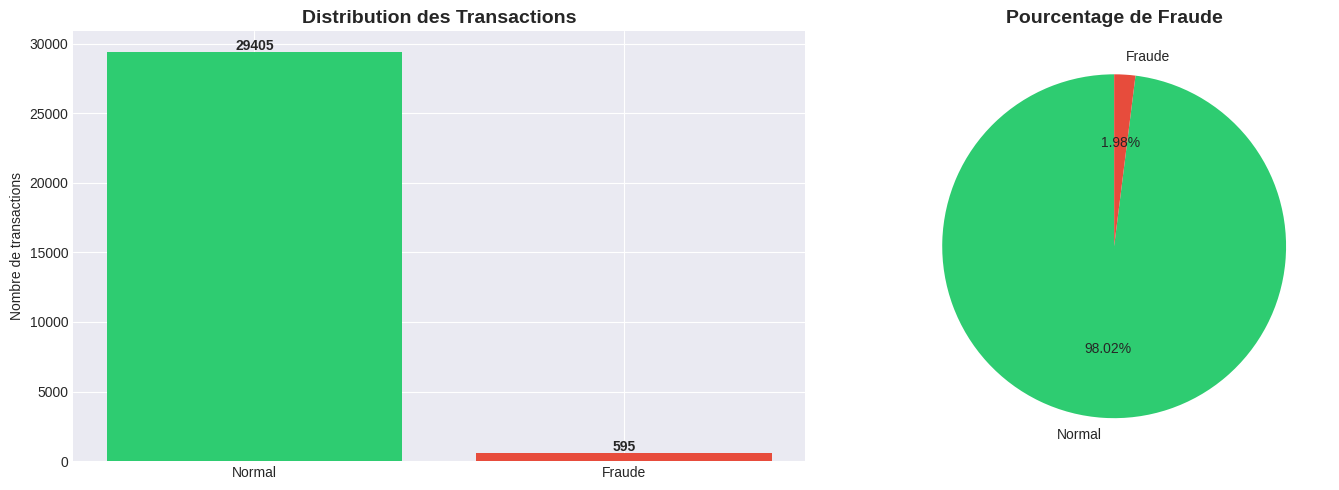


📊 Taux de fraude global : 1.98%


In [26]:
# ============================================
# 2. DISTRIBUTION DE LA FRAUDE
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique en barres
fraud_counts = df['is_fraud'].value_counts()
axes[0].bar(['Normal', 'Fraude'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution des Transactions', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre de transactions')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Graphique circulaire
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100
axes[1].pie(fraud_pct.values, labels=['Normal', 'Fraude'], autopct='%1.2f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Pourcentage de Fraude', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Taux de fraude global : {fraud_pct[1]:.2f}%")

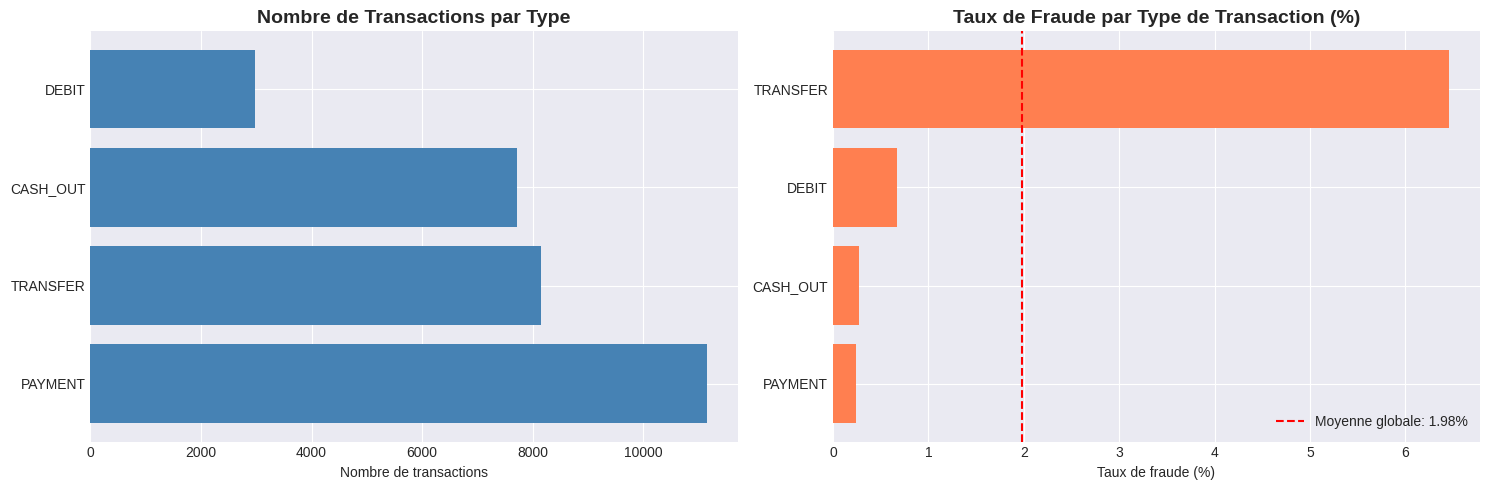


📈 Taux de fraude par type de transaction :
          sum  count  fraud_rate
type                            
PAYMENT    27  11150    0.242152
CASH_OUT   21   7716    0.272162
DEBIT      20   2974    0.672495
TRANSFER  527   8160    6.458333


In [27]:
# ============================================
# 3. ANALYSE PAR TYPE DE TRANSACTION
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Nombre de transactions par type
type_counts = df['type'].value_counts()
axes[0].barh(type_counts.index, type_counts.values, color='steelblue')
axes[0].set_title('Nombre de Transactions par Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nombre de transactions')

# Taux de fraude par type
fraud_by_type = df.groupby('type')['is_fraud'].agg(['sum', 'count', 'mean'])
fraud_by_type['fraud_rate'] = fraud_by_type['mean'] * 100
fraud_by_type = fraud_by_type.sort_values('fraud_rate', ascending=True)

axes[1].barh(fraud_by_type.index, fraud_by_type['fraud_rate'], color='coral')
axes[1].set_title('Taux de Fraude par Type de Transaction (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Taux de fraude (%)')
axes[1].axvline(fraud_pct[1], color='red', linestyle='--', label=f'Moyenne globale: {fraud_pct[1]:.2f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n📈 Taux de fraude par type de transaction :")
print(fraud_by_type[['sum', 'count', 'fraud_rate']])

/tmp/ipython-input-1250133420.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='is_fraud', y='amount', ax=axes[1, 1], palette=['#2ecc71', '#e74c3c'])
/tmp/ipython-input-1250133420.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Normal', 'Fraude'])


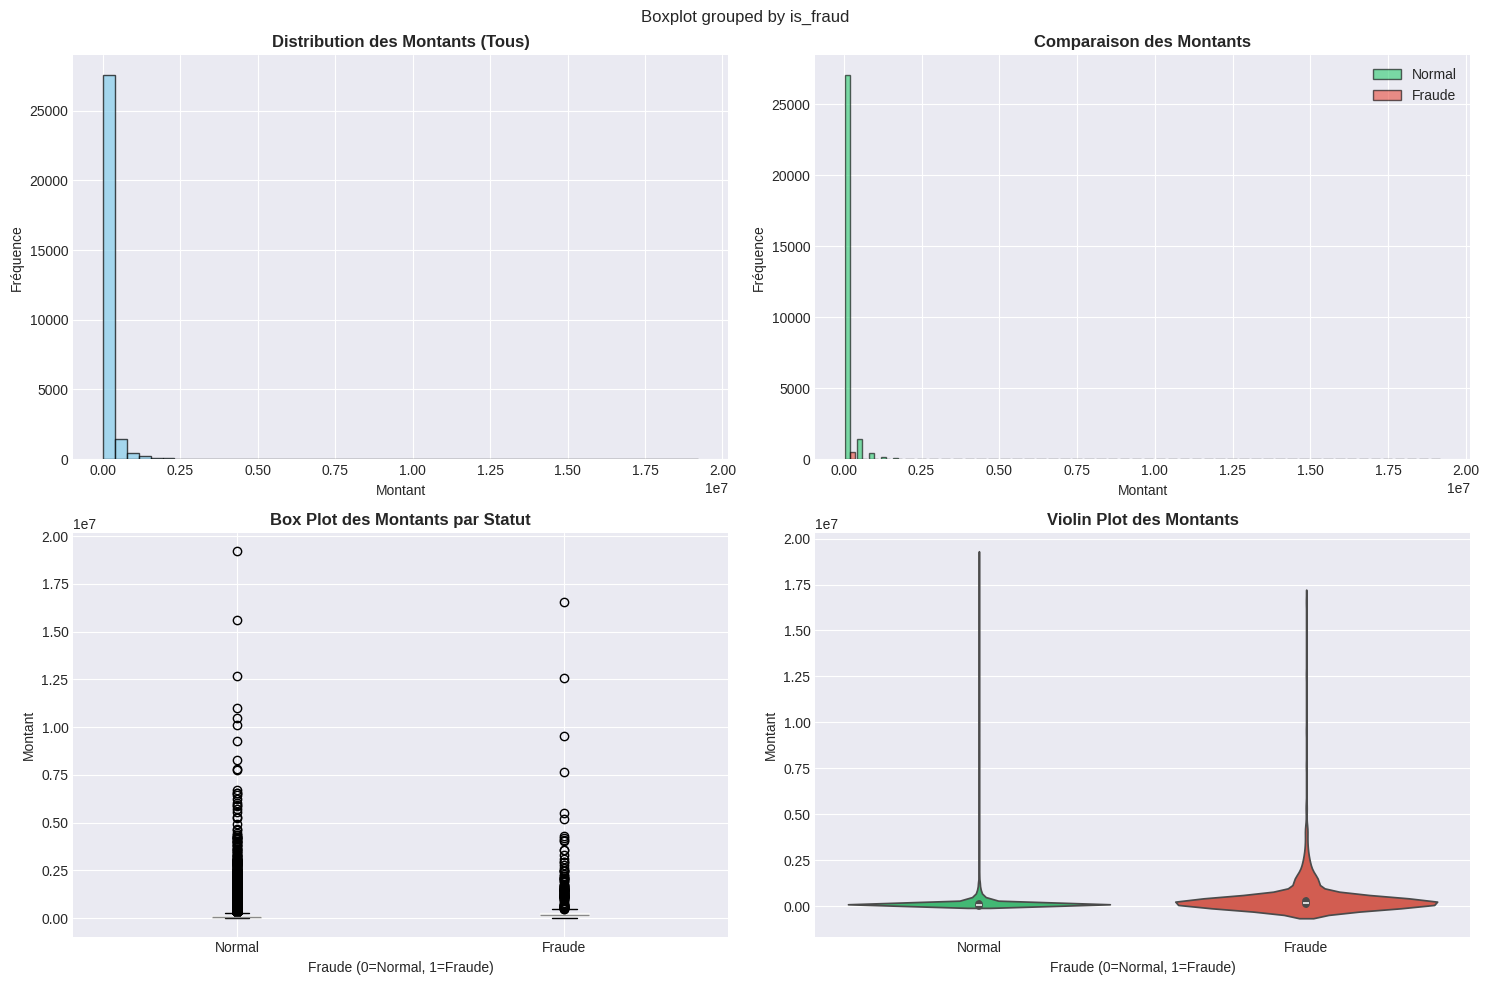


💰 Statistiques des montants :
            count           mean           std     min       25%       50%  \
is_fraud                                                                     
0         29405.0  140615.514368  3.767579e+05   100.0   17400.0   47500.0   
1           595.0  486999.831933  1.185774e+06  1100.0  110000.0  155000.0   

               75%         max  
is_fraud                        
0         130500.0  19214000.0  
1         255000.0  16558000.0  


In [28]:
# ============================================
# 4. DISTRIBUTION DES MONTANTS
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution globale des montants
axes[0, 0].hist(df['amount'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution des Montants (Tous)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Montant')
axes[0, 0].set_ylabel('Fréquence')

# Comparaison Normal vs Fraude
normal_amounts = df[df['is_fraud'] == 0]['amount']
fraud_amounts = df[df['is_fraud'] == 1]['amount']

axes[0, 1].hist([normal_amounts, fraud_amounts], bins=50, label=['Normal', 'Fraude'],
                color=['#2ecc71', '#e74c3c'], alpha=0.6, edgecolor='black')
axes[0, 1].set_title('Comparaison des Montants', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Montant')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].legend()

# Box plot
df.boxplot(column='amount', by='is_fraud', ax=axes[1, 0], patch_artist=True)
axes[1, 0].set_title('Box Plot des Montants par Statut', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Fraude (0=Normal, 1=Fraude)')
axes[1, 0].set_ylabel('Montant')
plt.sca(axes[1, 0])
plt.xticks([1, 2], ['Normal', 'Fraude'])

# Violin plot
sns.violinplot(data=df, x='is_fraud', y='amount', ax=axes[1, 1], palette=['#2ecc71', '#e74c3c'])
axes[1, 1].set_title('Violin Plot des Montants', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Fraude (0=Normal, 1=Fraude)')
axes[1, 1].set_ylabel('Montant')
axes[1, 1].set_xticklabels(['Normal', 'Fraude'])

plt.tight_layout()
plt.show()

print("\n💰 Statistiques des montants :")
print(df.groupby('is_fraud')['amount'].describe())

/tmp/ipython-input-442980973.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_age = df.groupby('age_group')['is_fraud'].mean() * 100


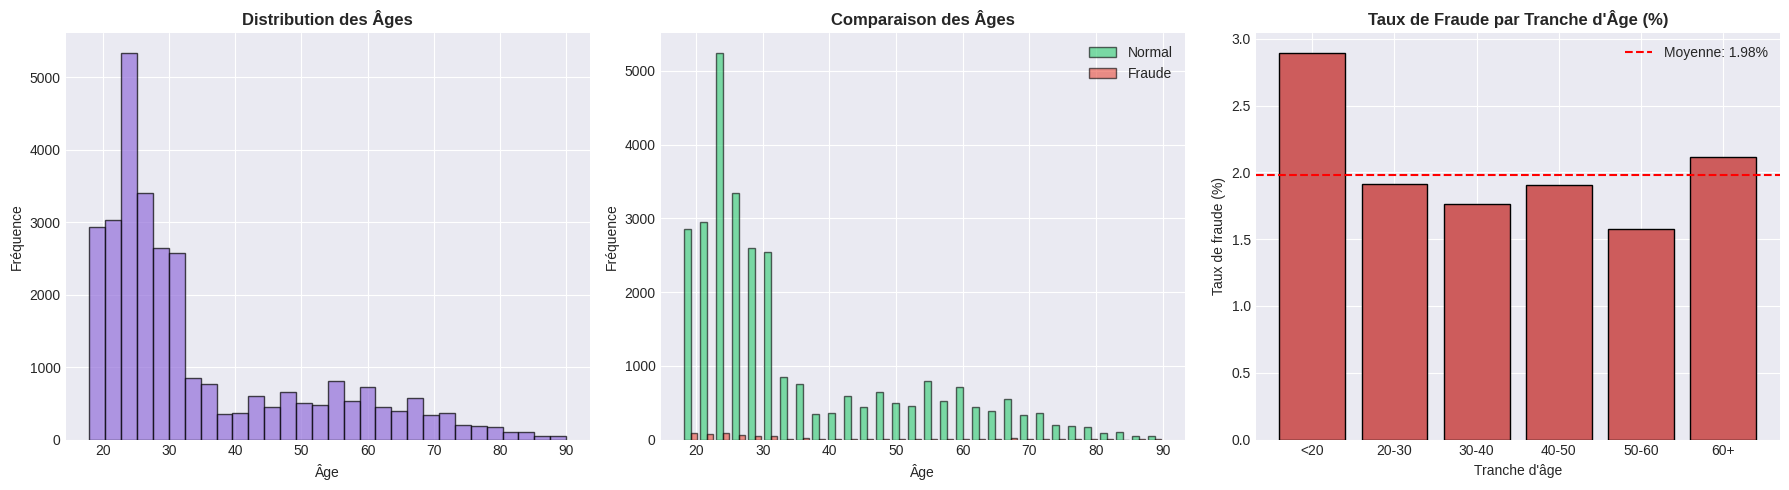


👥 Statistiques des âges :
            count       mean        std   min   25%   50%   75%   max
is_fraud                                                             
0         29405.0  34.532903  16.057592  18.0  23.0  28.0  43.0  90.0
1           595.0  33.721008  16.534002  18.0  22.0  27.0  40.0  88.0


In [29]:
# ============================================
# 5. ANALYSE PAR ÂGE
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution de l'âge
axes[0].hist(df['age'], bins=30, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des Âges', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Âge')
axes[0].set_ylabel('Fréquence')

# Comparaison Normal vs Fraude
axes[1].hist([df[df['is_fraud'] == 0]['age'], df[df['is_fraud'] == 1]['age']],
             bins=30, label=['Normal', 'Fraude'], color=['#2ecc71', '#e74c3c'],
             alpha=0.6, edgecolor='black')
axes[1].set_title('Comparaison des Âges', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Âge')
axes[1].set_ylabel('Fréquence')
axes[1].legend()

# Taux de fraude par tranche d'âge
age_bins = [0, 20, 30, 40, 50, 60, 100]
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])
fraud_by_age = df.groupby('age_group')['is_fraud'].mean() * 100
axes[2].bar(range(len(fraud_by_age)), fraud_by_age.values, color='indianred', edgecolor='black')
axes[2].set_title('Taux de Fraude par Tranche d\'Âge (%)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Tranche d\'âge')
axes[2].set_ylabel('Taux de fraude (%)')
axes[2].set_xticks(range(len(fraud_by_age)))
axes[2].set_xticklabels(fraud_by_age.index)
axes[2].axhline(fraud_pct[1], color='red', linestyle='--', label=f'Moyenne: {fraud_pct[1]:.2f}%')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n👥 Statistiques des âges :")
print(df.groupby('is_fraud')['age'].describe())


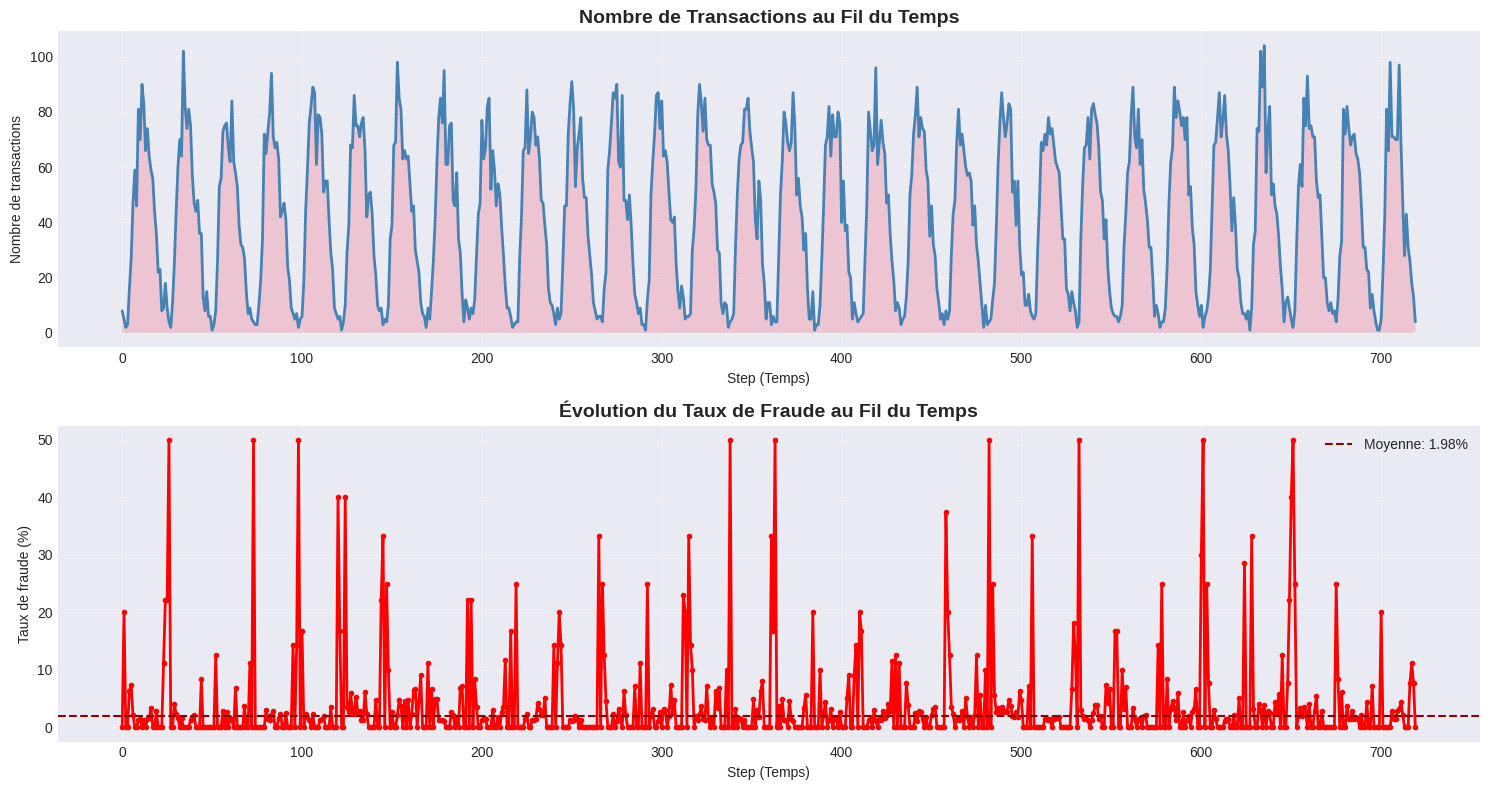

In [30]:
# ============================================
# 6. ÉVOLUTION TEMPORELLE (STEP)
# ============================================
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Nombre de transactions par step
step_counts = df.groupby('step').size()
axes[0].plot(step_counts.index, step_counts.values, color='steelblue', linewidth=2)
axes[0].fill_between(step_counts.index, step_counts.values, alpha=0.3)
axes[0].set_title('Nombre de Transactions au Fil du Temps', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Step (Temps)')
axes[0].set_ylabel('Nombre de transactions')
axes[0].grid(True, alpha=0.3)

# Taux de fraude par step
fraud_by_step = df.groupby('step')['is_fraud'].mean() * 100
axes[1].plot(fraud_by_step.index, fraud_by_step.values, color='red', linewidth=2, marker='o', markersize=3)
axes[1].axhline(fraud_pct[1], color='darkred', linestyle='--', label=f'Moyenne: {fraud_pct[1]:.2f}%')
axes[1].set_title('Évolution du Taux de Fraude au Fil du Temps', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Step (Temps)')
axes[1].set_ylabel('Taux de fraude (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

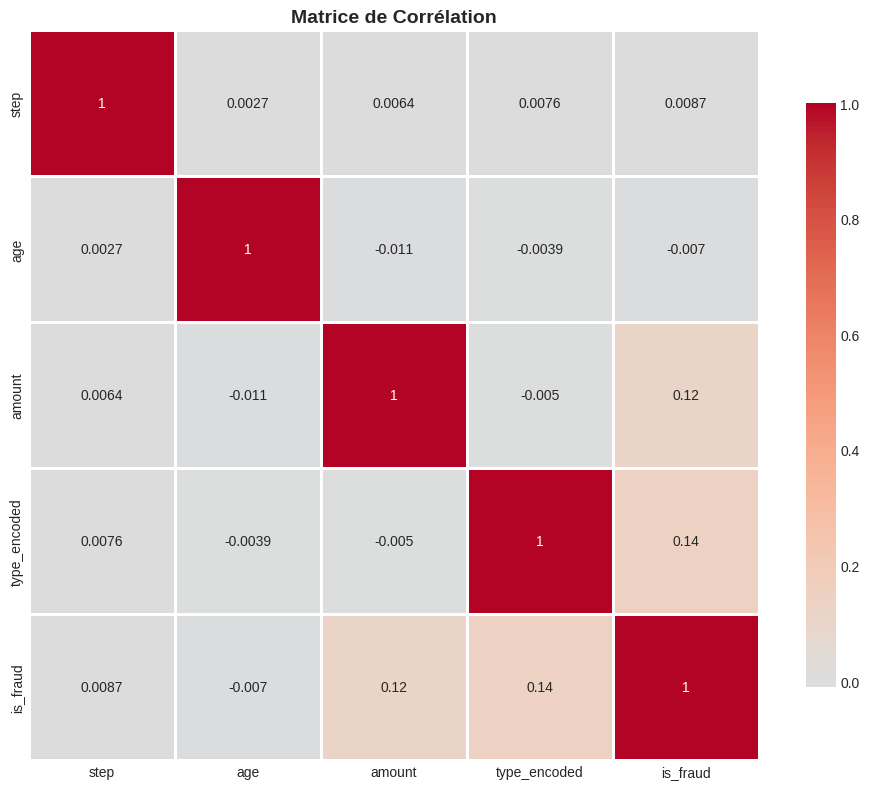

In [31]:
# ============================================
# 7. MATRICE DE CORRÉLATION
# ============================================
# Créer des variables numériques pour la corrélation
df_corr = df.copy()
df_corr['type_encoded'] = df_corr['type'].astype('category').cat.codes

# Calculer la corrélation
corr_matrix = df_corr[['step', 'age', 'amount', 'type_encoded', 'is_fraud']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

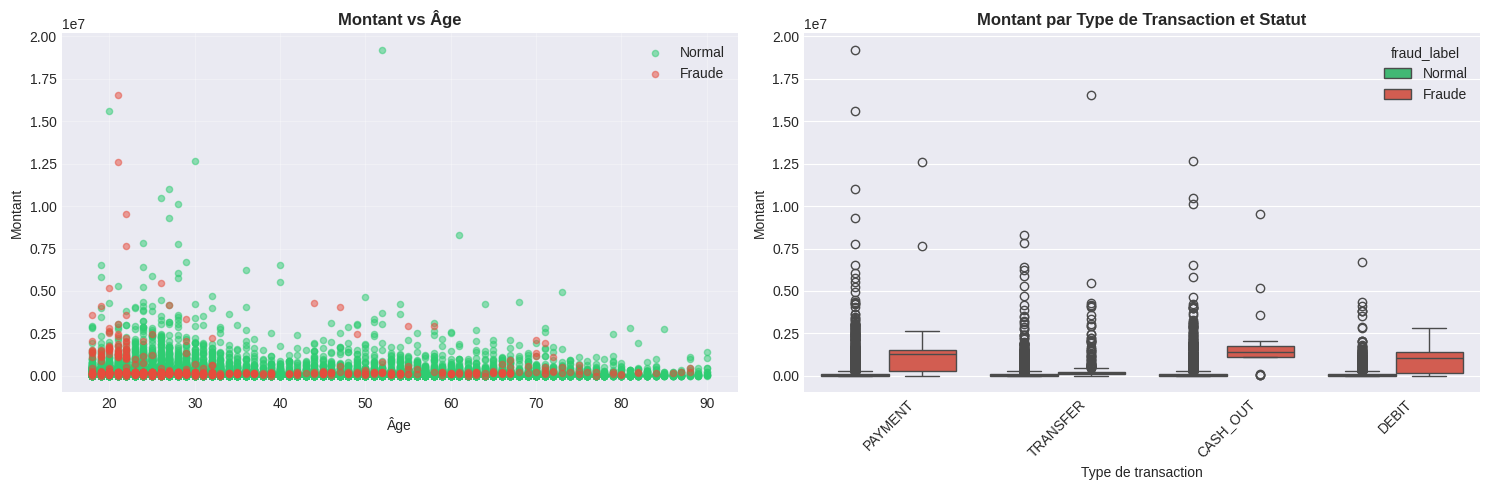


✅ ANALYSE EXPLORATOIRE TERMINÉE


In [32]:
# ============================================
# 8. ANALYSE MULTIVARIÉE
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Montant vs Âge
for fraud_status in [0, 1]:
    subset = df[df['is_fraud'] == fraud_status]
    label = 'Fraude' if fraud_status == 1 else 'Normal'
    color = '#e74c3c' if fraud_status == 1 else '#2ecc71'
    axes[0].scatter(subset['age'], subset['amount'], alpha=0.5, label=label,
                   color=color, s=20)

axes[0].set_title('Montant vs Âge', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Âge')
axes[0].set_ylabel('Montant')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot: Montant par Type et Fraude
df_viz = df.copy()
df_viz['fraud_label'] = df_viz['is_fraud'].map({0: 'Normal', 1: 'Fraude'})
sns.boxplot(data=df_viz, x='type', y='amount', hue='fraud_label', ax=axes[1],
            palette={'Normal': '#2ecc71', 'Fraude': '#e74c3c'})
axes[1].set_title('Montant par Type de Transaction et Statut', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Type de transaction')
axes[1].set_ylabel('Montant')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("✅ ANALYSE EXPLORATOIRE TERMINÉE")
print("=" * 50)